In [1]:
import sys
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter

import pitszi

# Define instrumental filtering

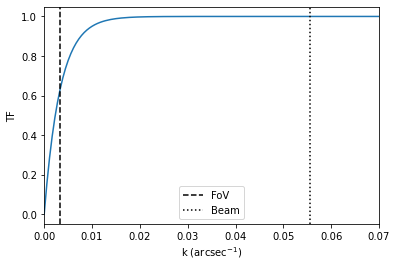

In [2]:
beamFWHM = 18 *u.arcsec

karcsec = np.linspace(0, 1/(beamFWHM.to_value('arcsec'))*10, 1000)
kfov = 1/(5*60)
TF = {'k':karcsec*u.arcsec**-1, 'TF':1-np.exp(-karcsec/kfov)}

#----- Plot
plt.plot(TF['k'], TF['TF'])
plt.axvline(kfov, ls='--', color='k', label='FoV')
plt.axvline(1/beamFWHM.to_value('arcsec'), ls=':', color='k', label='Beam')
plt.xlabel('k (arcsec$^{-1}$)')
plt.ylabel('TF')
plt.xlim(0, 0.07)
plt.legend()

# Cluster model

In [3]:
c = pitszi.Model(RA=60*u.deg, Dec=60*u.deg, redshift=0.4, M500=1e15*u.Msun, silent=False)

c.set_pressure_profile_universal_param('A10MD')

c.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                'Norm': 0.5, 
                                'slope': -11/3.,
                                'Linj': 1*u.Mpc,
                                'Ldis': 10*u.kpc}

cluster.triaxiality = {'min_to_maj_axis_ratio':0.8, 'int_to_maj_axis_ratio':1,
                       'euler_angle1':0*u.deg, 'euler_angle2':90*u.deg, 'euler_angle3':45*u.deg}
        
c.map_coord  = SkyCoord(60*u.deg, 60*u.deg, frame="icrs")
c.map_fov   = [6, 6]*u.arcmin
c.map_reso  = 2*u.arcsec
c.los_reso  = 10*u.kpc
c.R_truncation = c.R500*3

seed = 0


print('')
print('----- Scale -----')
print('beam in kpc: ', (c.D_ang*(beamFWHM).to_value('rad')).to('kpc'))
print('Pixel size in kpc: ', (c.D_ang*(c.map_reso).to_value('rad')).to('kpc'))
print('FoV in Mpc: ', (c.D_ang*(c.map_fov[0]).to_value('rad')).to('Mpc'))

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
Setting gNFW Planck coll. (2013) UPP.
Setting gNFW Arnaud et al. (2010) morphologically disturbed.
Setting model_pressure_fluctuation value
Fixing: R500 if involved
Setting the map coordinates
Setting: map_header to None, as map properties are now set by hand
Setting the map field of view
Setting: map_header to None, as map properties are now set by hand
Setting the map resolution value
Setting: map_header to None, as map properties are now set by hand
Setting the physical resolution value
Setting R_truncation value
Setting: theta_truncation ; Fixing: D_ang

----- Sc

Text(0.5, 1.0, 'Fluctuation pressure power spectrum')

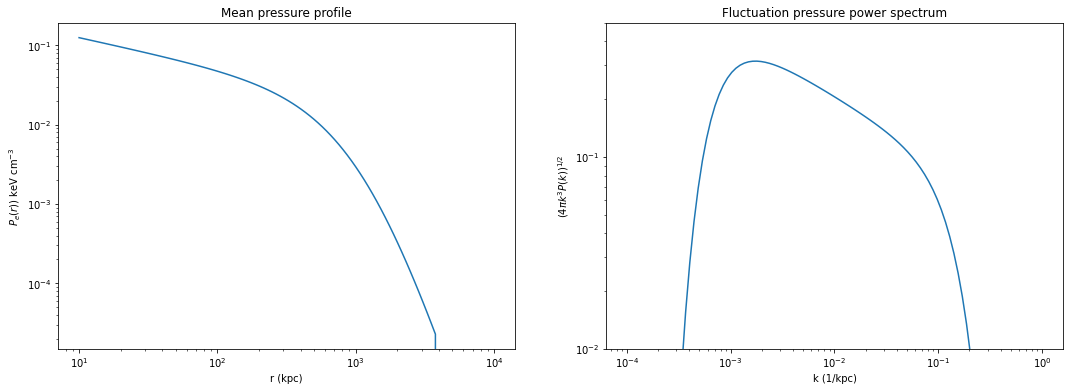

In [4]:
r, p_r = c.get_pressure_profile(radius=np.logspace(1,4,100)*u.kpc)

k, pk = c.get_pressure_fluctuation_spectrum(kvec=np.logspace(-1,3,100)*u.Mpc**-1)

plt.figure(0, figsize=(18,6))
ax = plt.subplot(1, 2, 1)
plt.loglog(r, p_r)
plt.xlabel('r (kpc)')
plt.ylabel(r'$P_e(r))$ keV cm$^{-3}$')
plt.title('Mean pressure profile')

ax = plt.subplot(1, 2, 2)
plt.loglog(k.to_value('kpc-1'), np.sqrt(4*np.pi*k**3*pk).to_value(''))
plt.xlabel('k (1/kpc)')
plt.ylabel(r'$(4 \pi k^3 P(k))^{1/2}$')
plt.ylim(1e-2,5e-1)
plt.title('Fluctuation pressure power spectrum')

In [5]:
fluct3d = c.get_pressure_cube_fluctuation(seed=seed)
prof3d  = c.get_pressure_cube_profile()

compton = c.get_sz_map(seed=seed)
compton_sph = c.get_sz_map(no_fluctuations=True)

     kmin input = 0.0002 ,     kmin sampling = 0.00012376237623762376
     kmax input = 0.5 ,     kmax sampling = 0.055985441328763555
     Expected rms over the full k range: 0.5
     Expected rms given the missing k range: 0.48303683988487733
     MeasureActual rms for this noise realization: 0.48411596799377143
     kmin input = 0.0002 ,     kmin sampling = 0.00012376237623762376
     kmax input = 0.5 ,     kmax sampling = 0.055985441328763555
     Expected rms over the full k range: 0.5
     Expected rms given the missing k range: 0.48303683988487733
     MeasureActual rms for this noise realization: 0.48411596799377143


Text(0.5, 1.0, 'delta P at z=0')

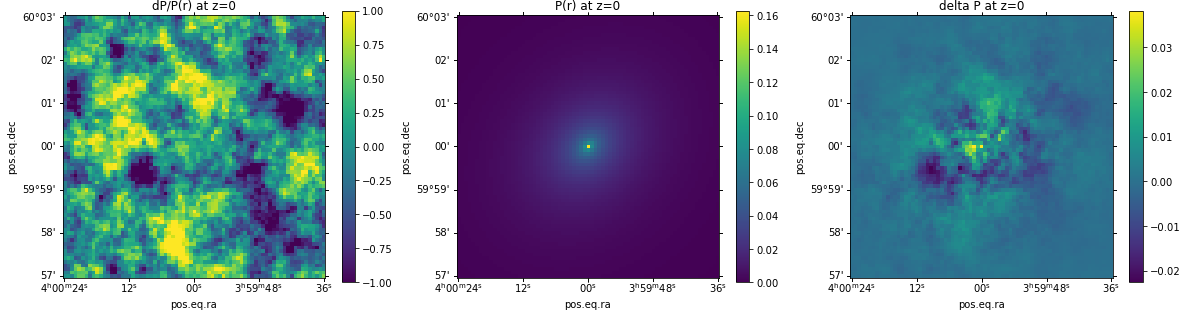

In [6]:
#----- Show the pressure fluctuation cube slice
plt.figure(figsize=(20,5))
ax = plt.subplot(1, 3, 1, projection=WCS(c.get_map_header()))
plt.imshow(fluct3d[:,:,int(fluct3d.shape[2]/2)], vmin=-1, vmax=1)
plt.colorbar()
plt.title('dP/P(r) at z=0')

ax = plt.subplot(1, 3, 2, projection=WCS(c.get_map_header()))
plt.imshow(prof3d[:,:,int(fluct3d.shape[2]/2)], vmin=0)
plt.colorbar()
plt.title('P(r) at z=0')

ax = plt.subplot(1, 3, 3, projection=WCS(c.get_map_header()))
plt.imshow((prof3d*fluct3d)[:,:,int(fluct3d.shape[2]/2)])
plt.colorbar()
plt.title('delta P at z=0')

In [7]:
#----- Beam application
compton_filt1 = pitszi.utils.apply_transfer_function(compton, c.map_reso.to_value('arcsec'), beamFWHM.to_value('arcsec'), TF, apps_TF_LS=False)
compton_sph_filt1 = pitszi.utils.apply_transfer_function(compton_sph, c.map_reso.to_value('arcsec'), beamFWHM.to_value('arcsec'), TF, apps_TF_LS=False)

#----- LSS + beam
compton_filt2 = pitszi.utils.apply_transfer_function(compton, c.map_reso.to_value('arcsec'), beamFWHM.to_value('arcsec'), TF, apps_TF_LS=True)
compton_sph_filt2 = pitszi.utils.apply_transfer_function(compton_sph, c.map_reso.to_value('arcsec'), beamFWHM.to_value('arcsec'), TF, apps_TF_LS=True)

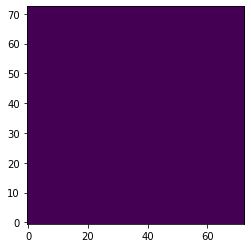

In [8]:
mask = compton*0+1
mask[compton_sph < -0.1 * np.amax(compton_sph)] = 0
plt.imshow(mask, origin='lower')

Text(0.5, 1.0, 'Fluctuation + beam smoothing + TF')

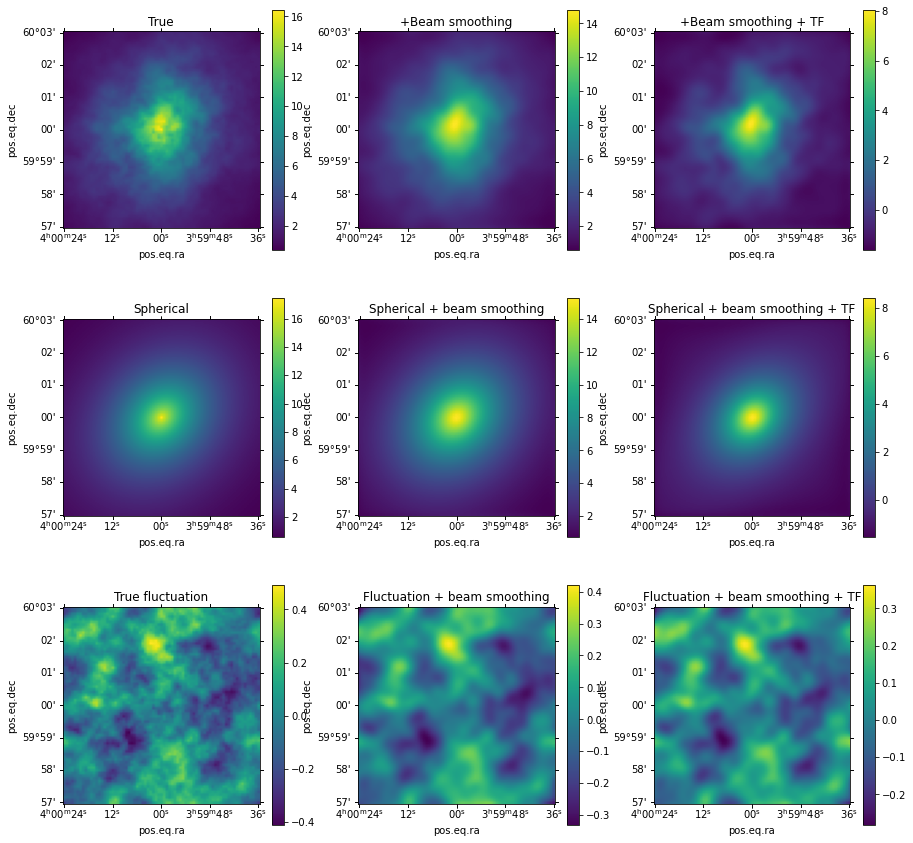

In [9]:
plt.figure(figsize=(15,15))
ax = plt.subplot(3, 3, 1, projection=WCS(c.get_map_header()))
plt.imshow(compton*1e5)
plt.colorbar()
plt.title('True')

ax = plt.subplot(3, 3, 2, projection=WCS(c.get_map_header()))
plt.imshow(compton_filt1*1e5)
plt.colorbar()
plt.title('+Beam smoothing')

ax = plt.subplot(3, 3, 3, projection=WCS(c.get_map_header()))
plt.imshow(compton_filt2*1e5)
plt.colorbar()
plt.title('+Beam smoothing + TF')

ax = plt.subplot(3, 3, 4, projection=WCS(c.get_map_header()))
plt.imshow(compton_sph*1e5)
plt.colorbar()
plt.title('Spherical')

ax = plt.subplot(3, 3, 5, projection=WCS(c.get_map_header()))
plt.imshow(compton_sph_filt1*1e5)
plt.colorbar()
plt.title('Spherical + beam smoothing')

ax = plt.subplot(3, 3, 6, projection=WCS(c.get_map_header()))
plt.imshow(compton_sph_filt2*1e5)
plt.colorbar()
plt.title('Spherical + beam smoothing + TF')

ax = plt.subplot(3, 3, 7, projection=WCS(c.get_map_header()))
plt.imshow((compton-compton_sph)/compton_sph)
plt.colorbar()
plt.title('True fluctuation')

ax = plt.subplot(3, 3, 8, projection=WCS(c.get_map_header()))
plt.imshow((compton_filt1-compton_sph_filt1)/compton_sph)
plt.colorbar()
plt.title('Fluctuation + beam smoothing')

ax = plt.subplot(3, 3, 9, projection=WCS(c.get_map_header()))
plt.imshow((compton_filt2-compton_sph_filt2)/compton_sph)
plt.colorbar()
plt.title('Fluctuation + beam smoothing + TF')

In [10]:
image   = (compton-compton_sph)/compton_sph
image0  = (compton-compton_sph)/compton_sph*mask
image1  = (compton_filt1-compton_sph_filt1)/compton_sph*mask
image2  = (compton_filt2-compton_sph_filt2)/compton_sph*mask
fsky = np.sum(mask)/mask.size

In [11]:
k2d, pk2d  = pitszi.utils.get_pk2d(image,  c.map_reso.to_value('arcsec'), Nbin=50)
k2d, pk2d0 = pitszi.utils.get_pk2d(image0, c.map_reso.to_value('arcsec'), Nbin=50)
k2d, pk2d1 = pitszi.utils.get_pk2d(image1, c.map_reso.to_value('arcsec'), Nbin=50)
k2d, pk2d2 = pitszi.utils.get_pk2d(image2, c.map_reso.to_value('arcsec'), Nbin=50)

k2d, pk2d_are  = pitszi.utils.get_pk2d_arevalo(image,  k2d, c.map_reso.to_value('arcsec'), mask=None, unbiais=True)
k2d, pk2d_are0 = pitszi.utils.get_pk2d_arevalo(image0, k2d, c.map_reso.to_value('arcsec'), mask=mask, unbiais=True)
k2d, pk2d_are1 = pitszi.utils.get_pk2d_arevalo(image1, k2d, c.map_reso.to_value('arcsec'), mask=mask, unbiais=True)
k2d, pk2d_are2 = pitszi.utils.get_pk2d_arevalo(image2, k2d, c.map_reso.to_value('arcsec'), mask=mask, unbiais=True)

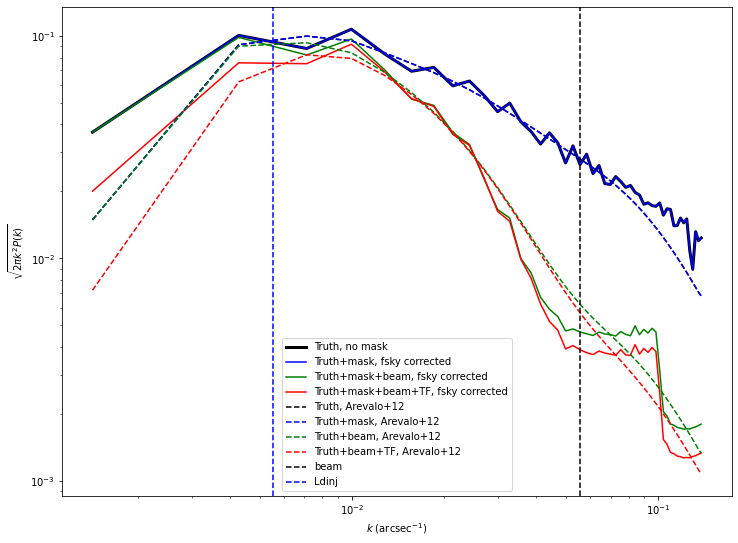

In [20]:
plt.figure(figsize=(12,9))
plt.loglog(k2d, np.sqrt(2*np.pi*k2d**2*pk2d),       lw=3, color='k', label='Truth, no mask')
plt.loglog(k2d, np.sqrt(2*np.pi*k2d**2*pk2d0/fsky), color='b', label='Truth+mask, fsky corrected')
plt.loglog(k2d, np.sqrt(2*np.pi*k2d**2*pk2d1/fsky), color='g', label='Truth+mask+beam, fsky corrected')
plt.loglog(k2d, np.sqrt(2*np.pi*k2d**2*pk2d2/fsky), color='r', label='Truth+mask+beam+TF, fsky corrected')
plt.loglog(k2d, np.sqrt(2*np.pi*k2d**2*pk2d_are),  ls='--', color='k', label='Truth, Arevalo+12')
plt.loglog(k2d, np.sqrt(2*np.pi*k2d**2*pk2d_are0), ls='--', color='b', label='Truth+mask, Arevalo+12')
plt.loglog(k2d, np.sqrt(2*np.pi*k2d**2*pk2d_are1), ls='--', color='g',  label='Truth+beam, Arevalo+12')
plt.loglog(k2d, np.sqrt(2*np.pi*k2d**2*pk2d_are2), ls='--', color='r',  label='Truth+beam+TF, Arevalo+12')
plt.xlabel(r'$k$ (arcsec$^{-1}$)')
plt.ylabel(r'$\sqrt{2 \pi k^2 P(k)}$')
plt.axvline(1/beamFWHM.to_value('arcsec'), color='k', ls='--', label='beam')
#plt.axvline(1/((c.model_pressure_fluctuation['Ldis']/c.D_ang).to_value('')*3600*180/np.pi), color='r', ls='--', label='Ldis')
plt.axvline(1/((c.model_pressure_fluctuation['Linj']/c.D_ang).to_value('')*3600*180/np.pi), color='b', ls='--', label='Ldinj')
#plt.ylim(2e-3,2e-1)
plt.legend()

In [ ]:
for isim in range(Nsim):
    compton = c.get_sz_map()
    compton_sph = c.get_sz_map(no_fluctuations=True)
    
    compton_filt1 = pitszi.utils.apply_transfer_function(compton, c.map_reso.to_value('arcsec'), beamFWHM.to_value('arcsec'), TF, apps_TF_LS=False)
    compton_sph_filt1 = pitszi.utils.apply_transfer_function(compton_sph, c.map_reso.to_value('arcsec'), beamFWHM.to_value('arcsec'), TF, apps_TF_LS=False)

    compton_filt2 = pitszi.utils.apply_transfer_function(compton, c.map_reso.to_value('arcsec'), beamFWHM.to_value('arcsec'), TF, apps_TF_LS=True)
    compton_sph_filt2 = pitszi.utils.apply_transfer_function(compton_sph, c.map_reso.to_value('arcsec'), beamFWHM.to_value('arcsec'), TF, apps_TF_LS=True)
    
    
    k2d, pk2d  = pitszi.utils.get_pk2d(image,  c.map_reso.to_value('arcsec'), Nbin=50)
    k2d, pk2d0 = pitszi.utils.get_pk2d(image0, c.map_reso.to_value('arcsec'), Nbin=50)
    k2d, pk2d1 = pitszi.utils.get_pk2d(image1, c.map_reso.to_value('arcsec'), Nbin=50)
    k2d, pk2d2 = pitszi.utils.get_pk2d(image2, c.map_reso.to_value('arcsec'), Nbin=50)

    k2d, pk2d_are  = pitszi.utils.get_pk2d_arevalo(image,  k2d, c.map_reso.to_value('arcsec'), mask=None, unbiais=True)
    k2d, pk2d_are0 = pitszi.utils.get_pk2d_arevalo(image0, k2d, c.map_reso.to_value('arcsec'), mask=mask, unbiais=True)
    k2d, pk2d_are1 = pitszi.utils.get_pk2d_arevalo(image1, k2d, c.map_reso.to_value('arcsec'), mask=mask, unbiais=True)
    k2d, pk2d_are2 = pitszi.utils.get_pk2d_arevalo(image2, k2d, c.map_reso.to_value('arcsec'), mask=mask, unbiais=True)
    